In [1]:
import pandas as pd
import numpy as np
import os
import sys
from scipy import sparse
from tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.metrics import *
import joblib
import time

import warnings
warnings.filterwarnings("ignore")
import argparse

import torch
import torch.nn as nn
from torch.optim import Adam

import gc

import warnings
warnings.filterwarnings("ignore")
import argparse

import torch
import torch.nn as nn
from torch.optim import Adam

from metrics import Metrics
import random
from random import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score
import torch
from torch.nn.utils.rnn import pad_sequence

In [2]:
data = pd.read_csv("training_data_inc_kg.gzip.csv",compression="gzip")

In [3]:
years_attempt = data.year.unique().tolist()

In [4]:
# User Attempts > 1 in a month

index_to_remove = []
for year in tqdm(years_attempt):
    months = sorted(data[data.year==year].month.unique().tolist())
    for month in months:
        df = data[(data.year==year)&(data.month==month)].copy().reset_index(drop=True)
        df = df.sort_values(by="attempt_created_at").reset_index(drop=True)
        filter_df = (df.groupby(["user_id"]).question_code.count()>1).reset_index()
        user_list = filter_df[filter_df.question_code==False].user_id.unique().tolist()
        indexes = df[df.user_id.isin(user_list)].index.tolist()
        index_to_remove = index_to_remove + indexes

100%|██████████| 6/6 [00:39<00:00,  6.62s/it]


In [5]:
data = data.drop(index=index_to_remove).reset_index(drop=True)

In [66]:
r_df = pd.read_csv("Relations.csv")

In [67]:
r_df = r_df[r_df.relationship_type.isin(["Prerequisite","Academic_sequence"])]
temp = r_df.groupby("from_concept_id").agg({"to_concept_id":lambda x :  (set(x))}).reset_index() 
temp_2 = r_df.groupby("to_concept_id").agg({"from_concept_id":lambda x :  (set(x))}).reset_index() 
temp = temp.rename(columns = {"from_concept_id":"concept_id"} )
temp_2 = temp_2.rename(columns = {"to_concept_id":"concept_id"} )
df = pd.merge(temp,temp_2,on="concept_id",how="outer")

In [68]:
df.to_concept_id.fillna("",inplace=True)
df.from_concept_id.fillna("",inplace=True) 

df["related_concepts"] =  df.apply(lambda x : set(x["to_concept_id"]).union(x["from_concept_id"]),axis=1)
df = df[["concept_id","related_concepts"]]  
df.related_concepts= df.related_concepts.apply(list)

In [69]:
r_df = df.copy()
del df

In [70]:
r_df["related_concepts"]= r_df["related_concepts"].apply(lambda x : ["new_"+str(i) for i in x ]) 

In [71]:
r_df["concept_id"] = r_df.concept_id.apply(lambda x: "new_"+x)

In [72]:
# Concepts with connection to attempted concepts matter in this experiment
r_df = r_df[r_df.concept_id.isin(data.concept_id.tolist())].reset_index(drop=True)

In [75]:
r_df["related_skill_ids"] = r_df["related_concepts"].apply(lambda x : [skill_stoi.get(y) for y in x])

In [78]:
r_df["skill_id"] = r_df["concept_id"].apply(lambda x : skill_stoi.get(x))

In [80]:
related_concept_dict = r_df.set_index("skill_id").to_dict()["related_skill_ids"]

In [81]:
torch.save(related_concept_dict,"related_concept_skill_mapping.dic")

In [79]:
r_df.to_csv("related_concepts.csv",index=False)

In [13]:
all_concepts =  r_df.concept_id.tolist()

for i in r_df.related_concepts.tolist():
    all_concepts.extend(i)

In [14]:
all_concepts.extend(data.concept_id.unique().tolist())

In [15]:
all_concepts = set(all_concepts) 
len(all_concepts)

29229

In [16]:
all_concepts = list(all_concepts)

In [46]:
# skill_itos = {k:v for k,v in enumerate(all_concepts)}
# skill_stoi = {v:k for k,v in enumerate(all_concepts)}

# torch.save(skill_itos,"Embibe_FT_Practice_Model_skill_itos_with_ucp_gradual_reduction.pt")
# torch.save(skill_stoi,"Embibe_FT_Practice_Model_skill_stoi_with_ucp_gradual_reduction.pt")

skill_itos = torch.load("Embibe_FT_Practice_Model_skill_itos_with_ucp_gradual_reduction.pt")

skill_stoi = torch.load("Embibe_FT_Practice_Model_skill_stoi_with_ucp_gradual_reduction.pt")

In [47]:
data["skill_id"] = data.concept_id.map(skill_stoi)

In [50]:
# r_df.concept_id = r_df.concept_id.map(skill_stoi)
# r_df.related_concepts = r_df.related_concepts.apply(lambda x : [skill_stoi[i] for i in x] )
# r_dict = dict(zip(r_df.concept_id.tolist(),r_df.related_concepts.tolist()))

In [51]:
matrix_len = len(skill_stoi)

In [52]:
%%time
if  not os.path.exists(f"./unrelated_penalty_gradual_reduction/unrelated_concept_dict.npz"):
    z= set(range(matrix_len)) 
    unrel_dict = {}
    for i in tqdm(range(matrix_len)): 
        unrel_dict[i] =  np.array(list(z.difference(r_dict.get(i,[])) ) )



    mat = np.zeros((matrix_len,matrix_len),dtype=np.int8)

    for i in tqdm(range(matrix_len)):
        mat[i][unrel_dict[i]] = 1 
        mat[i][i]=0
    
    
    np.save(f"./unrelated_penalty_gradual_reduction/unrelated_concept_dict.npy", mat )
    np.savez_compressed(f"./unrelated_penalty_gradual_reduction/unrelated_concept_dict", mat )
        
else : 
    print("LOADING MATRIX ")
    MATRIX =  np.load(f"./poc_dkt_kg_unrelated_concepts/unrelated_concept_dict.npz")["arr_0"]

LOADING MATRIX 
CPU times: user 2.52 s, sys: 180 ms, total: 2.7 s
Wall time: 2.69 s


In [53]:
MATRIX= torch.tensor(MATRIX).to("cuda")


In [55]:
del r_df,temp, temp_2#, mat
gc.collect()

In [56]:
num_items = len(skill_stoi)
num_items

29229

In [57]:
# Hyperparameter Configuration for PoC

SEED = 4
embed_inputs = True
drop_prob =0.2
batch_max_size = 8

embed_size = 256

hid_size = 256
num_hid_layers = 1
bptt = 100

num_epochs = 1

In [58]:
import torch.nn as nn
import torch.nn.functional as F


class DKT(nn.Module):
    def __init__(self, num_items, embed_inputs, embed_size, hid_size, num_hid_layers, drop_prob):
        """Deep knowledge tracing.
        
        Arguments:
            num_items (int): Number of items
            embed_inputs (bool): If True embed inputs, else one hot encoding
            embed_size (int): Input embedding dimension
            hid_size (int): Hidden layer dimension
            num_hid_layers (int): Number of hidden layers
            drop_prob (float): Dropout probability
        """
        super(DKT, self).__init__()
        self.num_items = num_items
        self.embed_inputs = embed_inputs

        if self.embed_inputs:
            self.input_embeds = nn.Embedding(2 * num_items + 1, embed_size, padding_idx=0)
            self.input_embeds.weight.requires_grad = True
            self.lstm = nn.LSTM(embed_size, hid_size, num_hid_layers,batch_first=True)
        else:
            self.lstm = nn.LSTM(2 * num_items + 1, hid_size, num_hid_layers,batch_first=True)
        
        self.bn = nn.BatchNorm1d(hid_size)
        self.dropout = nn.Dropout(p=drop_prob)
        
        self.out = nn.Linear(hid_size, num_items)

    def forward(self, inputs, hidden=None):
        if self.embed_inputs:
            embeds = self.input_embeds(inputs)
        else:
            embeds = F.one_hot(inputs, 2 * self.num_items + 1).float()
            
        out, hidden = self.lstm(embeds, hx=hidden)
        
        out = self.bn(out.permute(0,2,1)).permute(0,2,1)
        return self.out(self.dropout(out)), hidden
    
    def repackage_hidden(self, hidden, length):

        return tuple((v[:, -length:].detach().contiguous() for v in hidden))

In [59]:
model = DKT(num_items, embed_inputs=embed_inputs, embed_size=embed_size,hid_size=hid_size,
            num_hid_layers = num_hid_layers, drop_prob=drop_prob).cuda()

optimizer = Adam(model.parameters(), lr=1e-3)

In [60]:
print(model)

DKT(
  (input_embeds): Embedding(58459, 256, padding_idx=0)
  (lstm): LSTM(256, 256, batch_first=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (out): Linear(in_features=256, out_features=29229, bias=True)
)


In [61]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

23004205

In [62]:
list_of_my = []
years = data.year.unique().tolist()
for i in years:
    months = data[data.year==i].month.unique().tolist()
    for j in months:
        list_of_my.append(str(i)+"_"+str(j))

In [63]:
list_of_loss_coeff = [0.7 - i*0.009 for i in range(len(list_of_my))]

In [64]:
month_to_loss = {k:v for k,v in zip(list_of_my, list_of_loss_coeff)}

In [65]:
from metrics import Metrics

low_gpu_mem = False
step = 0
criterion = nn.BCEWithLogitsLoss(reduction="sum")
metrics = Metrics()

criterion_2 = nn.MSELoss(reduction="mean")


In [66]:
def compute_loss_new(preds, item_ids,  loss_fn=criterion_2):
    
    unrelated_concept_matrix = torch.index_select(MATRIX,0, item_ids )
    prediction_matrix = preds[1:,:] *  unrelated_concept_matrix[1:,:]
    label_matrix = preds[:-1,:] * unrelated_concept_matrix[:-1,:]
    prediction_matrix= torch.sigmoid(prediction_matrix)    
    label_matrix = torch.sigmoid(label_matrix)    
    return loss_fn(prediction_matrix, label_matrix)

def compute_loss(preds, item_ids, labels, criterion , criterion_2, month):
    labels = labels.view(-1)
    item_ids = item_ids.view(-1)[labels >= 0]
    preds = preds.view(-1, preds.shape[-1])[labels >= 0]
    
    loss_2 = compute_loss_new(preds,item_ids,criterion_2)
    preds = preds[torch.arange(preds.shape[0]), item_ids]
    div_val = labels[labels >= 0].sum()
    labels = labels[labels >= 0].float()
    loss= criterion(preds, labels)
    loss /= div_val   
    return loss + month_to_loss[month] * loss_2

In [67]:
def compute_auc(preds, item_ids, labels,is_train=False):
    """
    Compute AUC on the skills attempted
    Model at each sequence get the probability for all skills
    Will consider only probabilities for skill which was attempted by user
    """
    
    labels = labels.view(-1)
    item_ids = item_ids.view(-1)[labels >= 0]
    preds = preds.view(-1, preds.shape[-1])[labels >= 0]
    preds = preds[torch.arange(preds.shape[0]), item_ids]
    labels = labels[labels >= 0].float()

    if len(torch.unique(labels)) == 1: 
        auc = accuracy_score(labels, preds.round())
    else:
        auc = roc_auc_score(labels, preds)
        if is_train==False :
            precision,recall=precision_score(labels,preds.round()) , recall_score(labels,preds.round())
            acc =accuracy_score(labels, preds.round())
            return auc , precision,recall , acc
    return auc 


In [68]:
# Train & Validation Split
def get_data(df,num_items):
    data = [(torch.tensor(u_df["skill_id"].values, dtype=torch.long),
             torch.tensor(u_df["correctness"].values, dtype=torch.long),
             user_id )
            for user_id, u_df in tqdm_notebook(df.groupby("user_id"))] 
    
    data = [(torch.cat((torch.zeros(1, dtype=torch.long), item_ids + labels * num_items + 1))[:-1], item_ids, labels,user_id)
            for (item_ids, labels, user_id) in tqdm_notebook(data)] # [model_input, item_ids or skill_ids, attempt_correctness]

    np.random.seed(SEED)
    np.random.shuffle(data)
        
    return data

def prepare_batches(data, batch_size):
    """Prepare batches grouping padded sequences.
    
    Arguments:
        data (list of tuples of torch Tensor)
        batch_size (int): number of sequences per batch
        
    Output:
        batches (list of tuples of torch Tensor)
    """
    
    shuffle(data)
    batches = []

    for k in tqdm_notebook(range(0, len(data), batch_size)):
        batch = data[k:k + batch_size]
        inputs, item_ids, labels,user_id = zip(*batch)

        inputs = pad_sequence(inputs, batch_first=True, padding_value=0)     # Pad with 0
        item_ids = pad_sequence(item_ids, batch_first=True, padding_value=0) # Don't care
        labels = pad_sequence(labels, batch_first=True, padding_value=-1)    # Pad with -1

        batches.append([inputs, item_ids, labels])
        
    return batches


In [69]:
from datetime import datetime
from dateutil.relativedelta import relativedelta, MO
years_attempt = data.year.unique().tolist()

In [70]:
import logging
logging.basicConfig(
    filename="/home/brijesh_parmar/brijesh/unrelated_penalty_gradual_reduction/metric.log",
    filemode='a',
    format='%(name)s - %(levelname)s - %(message)s',
    level=logging.INFO
    )

In [71]:
# GCP payment issue lead to loading the last saved model
model.load_state_dict(torch.load("./unrelated_penalty_gradual_reduction/dkt_dfm_ft_emb_pract_ep_2020_5.pth"))

<All keys matched successfully>

In [72]:
data = data[(data.year>=2020)].reset_index(drop=True)

In [73]:
year_list = []
month_list = []
default_mastery_df = []
for year in [2020,2021]:
    months = sorted(data[data.year==year].month.unique().tolist())
    for month in months:
        if year==2020:
            if month<6:
                continue
        month_year = str(year)+"_"+str(month)
        print(month_year)
        df = data[(data.year==year)&(data.month==month)].copy().reset_index(drop=True)
        df = df.sort_values(by="attempt_created_at").reset_index(drop=True)
        filter_df = (df.groupby(["user_id"]).question_code.count()>1).reset_index()
        user_list = filter_df[filter_df.question_code==True].user_id.unique().tolist()
        df = df[df.user_id.isin(user_list)]
        df = df.sort_values(by="attempt_created_at").reset_index(drop=True)
        
        dt = datetime(year, month, 2, 0, 0, 0)
        delta = relativedelta(months=1)
        val_timestamp = dt + delta
        val_year = val_timestamp.year
        val_month = val_timestamp.month
        
        val_df = data[(data.year==val_year)&(data.month==val_month)].copy().reset_index(drop=True)
        filter_val_df = (val_df.groupby(["user_id"]).question_code.count()>1).reset_index()
        user_list_val = filter_val_df[filter_val_df.question_code==True].user_id.unique().tolist()
        val_df = val_df[val_df.user_id.isin(user_list_val)]
        val_df = val_df.sort_values(by="attempt_created_at").reset_index(drop=True)
        
        train_data = get_data(df,num_items)
        train_batches = prepare_batches(train_data, batch_max_size)
        
        val_data = get_data(val_df,num_items)
        val_batches = prepare_batches(val_data, batch_max_size)
        
        del train_data, val_data, df, val_df
        gc.collect()


        for epoch in tqdm_notebook(range(1)):

            print("\n\nTRAINING: EPOCH " + str(epoch+1))
            model.train()
            for inputs, item_ids, labels in tqdm_notebook(train_batches):
                batch_size, length = inputs.shape
                preds = torch.zeros(batch_size, length, model.num_items)

                # Put sequence on gpu by chunks (low gpu memory usage, slow)
                inputs, preds = inputs.cuda(), preds.cuda()
                preds , hidden = model(inputs)

                # loss = compute_loss(preds, item_ids.cuda(), labels.cuda(), criterion)
                loss = compute_loss(preds, item_ids.cuda(), labels.cuda(), criterion , criterion_2, month_year)
                preds = preds.detach().cpu()

                # loss /= labels[labels >= 0].sum()
                train_auc= compute_auc(preds, item_ids, labels,True)

                model.zero_grad()
                loss.backward()
                
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
                optimizer.step()
                step += 1
                metrics.store({'loss/train': loss.item()})
                metrics.store({'auc/train': train_auc})
                # Logging
                if step % 500 == 0:
                    print(metrics.average(), step)



            model.eval()
            
            mean_train_auc = []
            mean_train_precision = []
            mean_train_recall = []
            mean_train_acc = []
            for inputs, item_ids, labels in tqdm_notebook(train_batches):
                batch_size, length = inputs.shape

                with torch.no_grad():
                    if low_gpu_mem:
                        preds = torch.zeros(batch_size, length, model.num_items)
                        for i in range(0, length, bptt):
                            inp = inputs[:, i:i + bptt].cuda()
                            if i == 0:
                                pred, hidden = model(inp)
                            else:
                                hidden = model.repackage_hidden(hidden, inp.shape[1])
                                pred, hidden = model(inp, hidden)
                            preds[:, i:i + bptt] = torch.sigmoid(pred).cpu()

                    else:
                        inputs = inputs.cuda()
                        preds, _ = model(inputs)
                        preds = torch.sigmoid(preds).cpu()
                try:
                    train_auc,precision,recall,acc = compute_auc(preds, item_ids, labels)
                    mean_train_auc.append(train_auc)
                    mean_train_precision.append(precision)
                    mean_train_recall.append(recall)
                    mean_train_acc.append(acc)
                except:
                    acc = compute_auc(preds, item_ids, labels)
                    mean_train_acc.append(acc)
                    
            logging.info("Train- "+ "TimeStamp: "+str(month)+"_"+str(year)+
                         " AUC: "+ str(np.mean(mean_train_auc))+
                         " Precision: "+ str(np.mean(mean_train_precision))+
                        " Recall: "+ str(np.mean(mean_train_recall))+
                        " Accuracy: "+ str(np.mean(mean_train_acc)))
            
            
            print("\n\nValidation: EPOCH " + str(epoch+1))
            mean_val_auc = []
            mean_val_precision = []
            mean_val_recall = []
            mean_val_acc = []
            for inputs, item_ids, labels in tqdm_notebook(val_batches):
                batch_size, length = inputs.shape

                with torch.no_grad():
                    if low_gpu_mem:
                        preds = torch.zeros(batch_size, length, model.num_items)
                        for i in range(0, length, bptt):
                            inp = inputs[:, i:i + bptt].cuda()
                            if i == 0:
                                pred, hidden = model(inp)
                            else:
                                hidden = model.repackage_hidden(hidden, inp.shape[1])
                                pred, hidden = model(inp, hidden)
                            preds[:, i:i + bptt] = torch.sigmoid(pred).cpu()

                    else:
                        inputs = inputs.cuda()
                        preds, _ = model(inputs)
                        preds = torch.sigmoid(preds).cpu()
                try:
                    val_auc,precision,recall,acc = compute_auc(preds, item_ids, labels)
                    mean_val_auc.append(val_auc)
                    mean_val_precision.append(precision)
                    mean_val_recall.append(recall)
                    mean_val_acc.append(acc)
                except:
                    acc = compute_auc(preds, item_ids, labels)
                    mean_val_acc.append(acc)




            print("VAL_AUC : ", np.mean(mean_val_auc))
            print("VAL_Precision : ", np.mean(mean_val_precision))
            print("VAL_Recall : ", np.mean(mean_val_recall))
            print("VAL_Accuracy : ", np.mean(mean_val_acc))
            
            logging.info("Validation- "+ "TimeStamp: "+str(month)+"_"+str(year)+
                         " AUC: "+ str(np.mean(mean_val_auc))+
                         " Precision: "+ str(np.mean(mean_val_precision))+
                        " Recall: "+ str(np.mean(mean_val_recall))+
                        " Accuracy: "+ str(np.mean(mean_val_acc)))

            preds, _  = model(torch.tensor(np.array([0.0]),dtype=torch.long).reshape(1,1).to("cuda"))
            preds = torch.sigmoid(preds).cpu()
            df_mastery = preds[0][0].tolist()

            year_list.append(year)
            month_list.append(month)
            default_mastery_df.append(df_mastery)
        
            torch.save(model.state_dict(),f"./unrelated_penalty_gradual_reduction/dkt_dfm_ft_emb_pract_ep_{year}_{month}.pth")

2020_6




TRAINING: EPOCH 1


{'loss/train': 1.0325837141871452, 'auc/train': 0.701215174037542} 500
{'loss/train': 1.0130400075316428, 'auc/train': 0.6976503633323218} 1000
{'loss/train': 1.0070850673913956, 'auc/train': 0.6987282155709504} 1500
{'loss/train': 0.9882135373950005, 'auc/train': 0.7046254626614337} 2000






Validation: EPOCH 1



VAL_AUC :  0.7015065441895566
VAL_Precision :  0.6934675711782968
VAL_Recall :  0.8022916826582047
VAL_Accuracy :  0.6745070382512062

2020_7




TRAINING: EPOCH 1


{'loss/train': 1.0252304420471192, 'auc/train': 0.7029741593916864} 2500
{'loss/train': 1.0148797997832297, 'auc/train': 0.697763847094548} 3000
{'loss/train': 1.0022191613316536, 'auc/train': 0.7050174519076424} 3500
{'loss/train': 1.0175644450187684, 'auc/train': 0.7012715517941848} 4000
{'loss/train': 1.0356424053311348, 'auc/train': 0.7036750914931682} 4500






Validation: EPOCH 1



VAL_AUC :  0.7027793703456384
VAL_Precision :  0.676650431280476
VAL_Recall :  0.7957330903583779
VAL_Accuracy :  0.667096478488652

2020_8




TRAINING: EPOCH 1


{'loss/train': 1.070022174358368, 'auc/train': 0.7009941376541803} 5000
{'loss/train': 1.0564103039503097, 'auc/train': 0.7045655260134115} 5500
{'loss/train': 1.057404185116291, 'auc/train': 0.7043916208460529} 6000
{'loss/train': 1.0593015685081482, 'auc/train': 0.7051580290487126} 6500
{'loss/train': 1.0555125228762627, 'auc/train': 0.7041763690920776} 7000
{'loss/train': 1.0459032371640204, 'auc/train': 0.7058763830036999} 7500






Validation: EPOCH 1



VAL_AUC :  0.6826456135072989
VAL_Precision :  0.6633405356740806
VAL_Recall :  0.6934646435887588
VAL_Accuracy :  0.6453375541035343

2020_9




TRAINING: EPOCH 1


{'loss/train': 1.143383932352066, 'auc/train': 0.6854231269093257} 8000
{'loss/train': 1.1607894924879074, 'auc/train': 0.685757199293488} 8500
{'loss/train': 1.154769857287407, 'auc/train': 0.6889002746927119} 9000
{'loss/train': 1.1368306696414947, 'auc/train': 0.6924195221670645} 9500
{'loss/train': 1.141886550962925, 'auc/train': 0.6930515998265085} 10000
{'loss/train': 1.1615662176609038, 'auc/train': 0.6921607714770895} 10500






Validation: EPOCH 1



VAL_AUC :  0.6770815156908961
VAL_Precision :  0.6751689123868806
VAL_Recall :  0.6829944482940816
VAL_Accuracy :  0.6456269002730352

2020_10




TRAINING: EPOCH 1


{'loss/train': 1.1422255914211272, 'auc/train': 0.6801874595180681} 11000
{'loss/train': 1.1426048607826234, 'auc/train': 0.6779056178744053} 11500
{'loss/train': 1.115618461072445, 'auc/train': 0.6849587336762963} 12000






Validation: EPOCH 1



VAL_AUC :  0.672630475427935
VAL_Precision :  0.6631181371234857
VAL_Recall :  0.755700424987478
VAL_Accuracy :  0.6447421942381001

2020_11




TRAINING: EPOCH 1


{'loss/train': 1.1424135035276413, 'auc/train': 0.6774504520284066} 12500
{'loss/train': 1.095669251203537, 'auc/train': 0.6773112954707772} 13000






Validation: EPOCH 1



VAL_AUC :  0.6805538627552477
VAL_Precision :  0.6607859336574141
VAL_Recall :  0.7448220953310755
VAL_Accuracy :  0.6465845013396279

2020_12




TRAINING: EPOCH 1



VAL_AUC :  0.6758935881159128
VAL_Precision :  0.6660878776583745
VAL_Recall :  0.6980621863206975
VAL_Accuracy :  0.6414309720718806

2021_1




TRAINING: EPOCH 1


{'loss/train': 1.1423894469738007, 'auc/train': 0.6770181117121403} 14000
{'loss/train': 1.1469185794591903, 'auc/train': 0.676554892458454} 14500






Validation: EPOCH 1



VAL_AUC :  0.6789525153558167
VAL_Precision :  0.6485183668630045
VAL_Recall :  0.7526037531762941
VAL_Accuracy :  0.6406348967948354

2021_2




TRAINING: EPOCH 1


{'loss/train': 1.1428358711004256, 'auc/train': 0.6786231223212691} 15000






Validation: EPOCH 1



VAL_AUC :  nan
VAL_Precision :  nan
VAL_Recall :  nan
VAL_Accuracy :  nan



In [74]:
default_mastery_df = pd.DataFrame(default_mastery_df)
default_mastery_df["year"] = year_list
default_mastery_df["month"] = month_list
default_mastery_df = default_mastery_df.rename(columns=skill_itos)

In [75]:
default_mastery_df.to_csv("./unrelated_penalty_gradual_reduction/default_mastery_practice_ft_emb_unrelated_concepts.csv",index=False)

In [76]:
default_mastery_df

new_KG6472  new_KG34275  new_KG23248  new_KG15468  new_KG10001  \
0    0.499983     0.499935     0.499994     0.412904     0.636089   
1    0.499994     0.499934     0.499994     0.418448     0.626261   
2    0.499999     0.499934     0.499995     0.425278     0.537339   
3    0.500000     0.499934     0.499995     0.435516     0.469597   
4    0.500000     0.499934     0.499995     0.485996     0.439454   
5    0.500000     0.499934     0.499995     0.469345     0.460449   
6    0.500000     0.499934     0.499996     0.463208     0.497585   
7    0.500000     0.499934     0.499996     0.494672     0.451920   
8    0.500000     0.499934     0.499996     0.480275     0.452696   

   new_KG20093  new_KG15048  new_KG11786  new_KG4908  new_KG47145  ...  \
0     0.889363     0.416299     0.483695    0.500064     0.502937  ...   
1     0.904147     0.497196     0.517881    0.500064     0.502937  ...   
2     0.880846     0.509905     0.426658    0.500064     0.502937  ...   
3     0.823475     0.502294     0.427198    0.500064     0.502921  ...   
4     0.781284     0.474907     0.457153    0.500064     0.502919  ...   
5     0.845726     0.489002     0.482148    0.500064     0.502899  ...   
6     0.824881     0.511934     0.466746    0.500064     0.502884  ...   
7     0.810053     0.491672     0.432786    0.500064     0.502874  ...   
8     0.799133     0.486583     0.438369    0.500064     0.502872  ...   

   new_KG6118  new_KG4626  new_KG49383  new_KG47794  new_KG22979  new_KG12799  \
0    0.496240         0.5     0.496028     0.500661          0.5     0.338636   
1    0.498702         0.5     0.496169     0.500546          0.5     0.366543   
2    0.499624         0.5     0.496384     0.500412          0.5     0.399035   
3    0.499810         0.5     0.496652     0.500319          0.5     0.417961   
4    0.499861         0.5     0.496843     0.500287          0.5     0.425370   
5    0.499911         0.5     0.496888     0.500266          0.5     0.430253   
6    0.499937         0.5     0.496947     0.500236          0.5     0.434053   
7    0.499960         0.5     0.497023     0.500209          0.5     0.438125   
8    0.499962         0.5     0.497028     0.500203          0.5     0.440273   

   new_KG13860  new_KG2332  year  month  
0     0.396590    0.500079  2020      6  
1     0.403845    0.500065  2020      7  
2     0.460028    0.500052  2020      8  
3     0.388523    0.500043  2020      9  
4     0.376129    0.500036  2020     10  
5     0.350025    0.500032  2020     11  
6     0.315439    0.500030  2020     12  
7     0.309133    0.500028  2021      1  
8     0.375005    0.500028  2021      2  

[9 rows x 29231 columns]

In [77]:
concepts = []
users = []
year_list = []
month_list = []
new_concepts_added = []
new_users_added = []

for year in years_attempt:
    months = sorted(data[data.year==year].month.unique().tolist())
    for month in months:
        df = data[(data.year==year)&(data.month==month)].copy().reset_index(drop=True)
        df = df.sort_values(by="attempt_created_at").reset_index(drop=True)
        filter_df = (df.groupby(["user_id"]).question_code.count()>1).reset_index()
        user_list = filter_df[filter_df.question_code==True].user_id.unique().tolist()
        df = df[df.user_id.isin(user_list)]
        df = df.sort_values(by="attempt_created_at").reset_index(drop=True)
        year_list.append(year)
        month_list.append(month)
        new_concepts_added.append(len(set(df.concept_id.unique().tolist()).difference(concepts)))
        concepts = list(set(concepts + df.concept_id.unique().tolist()))
        new_users_added.append(len(set(df.user_id.unique().tolist()).difference(users)))
        users = list(set(users + df.user_id.unique().tolist()))

In [78]:
info_df = pd.DataFrame()
info_df["year"] = year_list
info_df["month"] = month_list
info_df["new_concepts_added"] = new_concepts_added
info_df["new_users_added"] = new_users_added

In [79]:
info_df.to_csv("./unrelated_penalty_gradual_reduction/New_Users_Concepts_added.csv",index=False)

In [80]:
with open("./unrelated_penalty_gradual_reduction/metric.log",mode="r") as f:
    lines = f.readlines()


metric_df = []
for i in range(len(lines)):
    line = lines[i].strip("\n").split(" ")
    metric_df.append(pd.DataFrame(line).T)

metric_df = pd.concat(metric_df)[[4,6,8,10,12,14]].reset_index(drop=True)
metric_df.columns = ["batch_type","month_year","AUC","Precision","Recall","Accuracy"]

metric_df["batch_type"] = metric_df["batch_type"].apply(lambda x : x.strip("-"))

metric_df.to_csv("./unrelated_penalty_gradual_reduction/Metric_details.csv",index=False)

# Simulation

In [1]:
import pandas as pd
import numpy as np
import os
import sys
from scipy import sparse
from tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.metrics import *
import joblib
import time

import warnings
warnings.filterwarnings("ignore")
import argparse

import torch
import torch.nn as nn
from torch.optim import Adam

import gc

import warnings
warnings.filterwarnings("ignore")
import argparse

import torch
import torch.nn as nn
from torch.optim import Adam

from metrics import Metrics
import random
from random import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score
import torch
from torch.nn.utils.rnn import pad_sequence

In [2]:
import torch.nn as nn
import torch.nn.functional as F


class DKT(nn.Module):
    def __init__(self, num_items, embed_inputs, embed_size, hid_size, num_hid_layers, drop_prob):
        """Deep knowledge tracing.
        
        Arguments:
            num_items (int): Number of items
            embed_inputs (bool): If True embed inputs, else one hot encoding
            embed_size (int): Input embedding dimension
            hid_size (int): Hidden layer dimension
            num_hid_layers (int): Number of hidden layers
            drop_prob (float): Dropout probability
        """
        super(DKT, self).__init__()
        self.num_items = num_items
        self.embed_inputs = embed_inputs

        if self.embed_inputs:
            self.input_embeds = nn.Embedding(2 * num_items + 1, embed_size, padding_idx=0)
            self.input_embeds.weight.requires_grad = True
            self.lstm = nn.LSTM(embed_size, hid_size, num_hid_layers,batch_first=True)
        else:
            self.lstm = nn.LSTM(2 * num_items + 1, hid_size, num_hid_layers,batch_first=True)
        
        self.bn = nn.BatchNorm1d(hid_size)
        self.dropout = nn.Dropout(p=drop_prob)
        
        self.out = nn.Linear(hid_size, num_items)

    def forward(self, inputs, hidden=None):
        if self.embed_inputs:
            embeds = self.input_embeds(inputs)
        else:
            embeds = F.one_hot(inputs, 2 * self.num_items + 1).float()
            
        out, hidden = self.lstm(embeds, hx=hidden)
        
        out = self.bn(out.permute(0,2,1)).permute(0,2,1)
        return self.out(self.dropout(out)), hidden
    
    def repackage_hidden(self, hidden, length):

        return tuple((v[:, -length:].detach().contiguous() for v in hidden))

In [3]:
skill_itos = torch.load("Embibe_FT_Practice_Model_skill_itos_with_ucp_gradual_reduction.pt")
skill_stoi = torch.load("Embibe_FT_Practice_Model_skill_stoi_with_ucp_gradual_reduction.pt")

In [4]:
num_items = len(skill_stoi)
num_items

29229

In [5]:
# Train & Validation Split
def get_data(df,num_items):
    data = [(torch.tensor(u_df["skill_id"].values, dtype=torch.long),
             torch.tensor(u_df["correctness"].values, dtype=torch.long),
             user_id )
            for user_id, u_df in tqdm_notebook(df.groupby("user_id"))] 
    
    data = [(torch.cat((torch.zeros(1, dtype=torch.long), item_ids + labels * num_items + 1))[:-1], item_ids, labels,user_id)
            for (item_ids, labels, user_id) in tqdm_notebook(data)] # [model_input, item_ids or skill_ids, attempt_correctness]

    np.random.seed(SEED)
    np.random.shuffle(data)
        
    return data

def prepare_batches(data, batch_size):
    """Prepare batches grouping padded sequences.
    
    Arguments:
        data (list of tuples of torch Tensor)
        batch_size (int): number of sequences per batch
        
    Output:
        batches (list of tuples of torch Tensor)
    """
    
    shuffle(data)
    batches = []

    for k in tqdm_notebook(range(0, len(data), batch_size)):
        batch = data[k:k + batch_size]
        inputs, item_ids, labels,user_id = zip(*batch)

        inputs = pad_sequence(inputs, batch_first=True, padding_value=0)     # Pad with 0
        item_ids = pad_sequence(item_ids, batch_first=True, padding_value=0) # Don't care
        labels = pad_sequence(labels, batch_first=True, padding_value=-1)    # Pad with -1

        batches.append([inputs, item_ids, labels])
        
    return batches


In [6]:
# Hyperparameter Configuration for PoC

SEED = 4
embed_inputs = True
drop_prob =0.2
batch_max_size = 8

embed_size = 256

hid_size = 256
num_hid_layers = 1
bptt = 100

num_epochs = 1

In [7]:
model = DKT(num_items, embed_inputs=embed_inputs, embed_size=embed_size,hid_size=hid_size,
            num_hid_layers = num_hid_layers, drop_prob=drop_prob).cuda()

optimizer = Adam(model.parameters(), lr=1e-3)

In [8]:
data = pd.read_csv("training_data_inc_kg.gzip.csv",compression="gzip")

In [160]:
model.load_state_dict(torch.load("unrelated_penalty_gradual_reduction/dkt_dfm_ft_emb_pract_ep_2021_1.pth"))

<All keys matched successfully>

In [10]:
relations = pd.read_csv("Relations.csv")
relations = relations[relations.relationship_type.isin(["Prerequisite","Academic_sequence"])]

In [11]:
relations["to_concept_id"] = relations.to_concept_id.apply(lambda x : "new_"+x)
relations["from_concept_id"] = relations.from_concept_id.apply(lambda x : "new_"+x)

relations["to_skill_id"] = relations.to_concept_id.map(skill_stoi)
relations["from_skill_id"] = relations.from_concept_id.map(skill_stoi)



In [12]:
concepts_df = data.groupby(["concept_id"]).question_code.count().sort_values().reset_index()
concepts = pd.read_csv("Concepts.csv")
concepts["concept_id"] = concepts["concept_id"].apply(lambda x : "new_"+x)
concepts_df.columns = ["concept_id","attempt_count"]

In [13]:
concepts.shape[0]

61736

In [14]:
concepts["skill_id"] = concepts.concept_id.map(skill_stoi)
concepts.shape[0]

61736

In [15]:
concepts = concepts.dropna(subset = ["skill_id"]).reset_index(drop=True)

In [17]:
id_to_name = concepts.set_index("skill_id").to_dict()["concept_name"]

In [33]:
data.sample(10)

question_code  attempt_created_at  correctness  \
8143316        6011293       1513329576000            1   
43145240     EM0039774       1590387933184            1   
2019017        6010280       1499777889000            1   
5126801        6005389       1508842911000            1   
45122846     EM0068787       1592902287360            0   
10700910     EM0155377       1519112159232            0   
8034165        6011424       1514470036000            1   
2682579        6005779       1500495133000            1   
22043784       6000396       1543242957000            1   
21214132       6012052       1541603024000            0   

                                       user_id   concept_id  year  month  \
8143316   932a078c-bfa0-4641-9685-5386297f3ee4  new_KG25687  2017     12   
43145240                            1250217916  new_KG14011  2020      5   
2019017   52d575f9-78df-4f34-be93-45f75b688b12  new_KG25534  2017      7   
5126801   40d393fd-5ac1-46d4-a580-3f10dc5c4a33   new_KG6093  2017     10   
45122846                            1348474032  new_KG11302  2020      6   
10700910                         22345577_14.0  new_KG19376  2018      2   
8034165   13f88651-fdd7-41d1-9517-06742dea9176  new_KG21367  2017     12   
2682579   89377fdb-a6f9-4680-9a93-6c966d16950b  new_KG25746  2017      7   
22043784  bc49bc17-38fb-47e9-90a7-b44e74f5b044   new_KG7502  2018     11   
21214132  2351f32d-b1ee-4317-80c1-2b7e3d519796   new_KG5632  2018     11   

          date  user_new_id  skill_id  
8143316     15          NaN     26329  
43145240    25          NaN      7828  
2019017     11          NaN      9285  
5126801     24          NaN     10165  
45122846    23          NaN     21930  
10700910    20         14.0      5361  
8034165     28          NaN     23094  
2682579     19          NaN     17546  
22043784    26          NaN       986  
21214132     7          NaN      1163

In [205]:
user_id = "932a078c-bfa0-4641-9685-5386297f3ee4"
sub_df = data[data.user_id==user_id].copy()
sub_df["concept_name"] = sub_df.skill_id.map(id_to_name)

In [206]:
# sub_df["skill_id"]= 25192

In [226]:
train_data = get_data(sub_df.head(20).tail(5),num_items)
train_batches = prepare_batches(train_data, batch_max_size)

In [227]:
model.eval()
for inputs, item_ids, labels in tqdm_notebook(train_batches):
    batch_size, length = inputs.shape

    with torch.no_grad():
        inputs = inputs.cuda()
        preds, _ = model(inputs)
        preds = torch.sigmoid(preds).cpu()

In [228]:
prediction_df = pd.DataFrame(preds[0].tolist())

In [230]:
prediction_df[sub_df.head(20).tail(2).skill_id.unique().tolist()]

870
0  0.671849
1  0.668097

In [231]:
sub_df.head(20).tail(5).reset_index(drop=True)

question_code  attempt_created_at  correctness  \
0       6000657       1500903582000            1   
1       6000661       1500903602000            1   

                                user_id   concept_id  year  month  date  \
0  932a078c-bfa0-4641-9685-5386297f3ee4  new_KG25748  2017      7    24   
1  932a078c-bfa0-4641-9685-5386297f3ee4  new_KG25748  2017      7    24   

   user_new_id  skill_id                                       concept_name  
0          NaN       870  General Solution of Trigonometric Equations: t...  
1          NaN       870  General Solution of Trigonometric Equations: t...

In [232]:
candidate = sub_df.head(20).tail(2).skill_id.unique().tolist()
new_candidates = []
for concept in candidate:
    new_candidates = new_candidates + related_concept_dict.get(concept,[])
new_candidates = list(set(new_candidates))
cols_to_keep = []
for i in  prediction_df[new_candidates].columns :
     if (prediction_df[new_candidates][i].apply(lambda x  : np.round(x,4)).nunique()) >4 :
        cols_to_keep.append(i)
cols_to_keep = sub_df.head(20).tail(5).skill_id.unique().tolist() + cols_to_keep

In [233]:
prediction_df[cols_to_keep].rename(columns=id_to_name)


Division of a Polynomial by a Binomial  \
0                                0.488335   
1                                0.488335   

   General Solution of Trigonometric Equations: tan^2(x) = tan^2(a) or |tanx| = |tana|  
0                                           0.671849                                    
1                                           0.668097

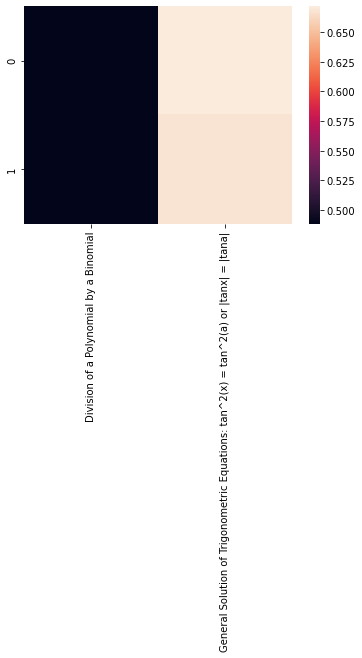

In [234]:
import seaborn as sns
ax = sns.heatmap(prediction_df[cols_to_keep],xticklabels=[id_to_name[x] for x in cols_to_keep])
